In [178]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy import stats

In [179]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_= pd.Series(series[name].values,index=series.index).ffill().dropna()
        x = pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x = x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0

In [180]:
monthlydf = pd.read_excel('./PredictorData2019.xlsx', sheet_name='Monthly')
quarterlydf = pd.read_excel('./PredictorData2019.xlsx', sheet_name='Quarterly')
annualdf = pd.read_excel('./PredictorData2019.xlsx', sheet_name='Annual')   

c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [181]:
annualdf.columns

Index(['yyyy', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'cay',
       'ntis', 'Rfree', 'infl', 'eqis', 'ltr', 'corpr', 'svar', 'csp', 'ik',
       'CRSP_SPvw', 'CRSP_SPvwx'],
      dtype='object')

In [182]:
quarterlydf.columns

Index(['yyyyq', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'cay', 'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'ik',
       'CRSP_SPvw', 'CRSP_SPvwx', 'D3', 'E3'],
      dtype='object')

In [183]:
monthlydf.columns

Index(['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx'],
      dtype='object')

In [184]:
def calced_cols(df): 
    #dividend price ratio
    df['dp'] = np.log(df['D12']) - np.log(df['Index'])

    #dividend yield
    df['dy'] = np.log(df['D12']) - np.log(df['Index'].shift(-1))

    #earnings price ratio
    df['ep'] = np.log(df['E12']) - np.log(df['Index'])

    #dividend payout ratio
    df['de'] = np.log(df['D12']) - np.log(df['E12'])

    #default yield spread
    df['dfy'] = df['BAA'] - df['AAA']

    #term spread
    df['tms'] = df['lty'] - df['tbl']

    #default return spread
    df['dfr'] = df['corpr'] - df['lty']
    
    return df




In [185]:
calced_monthly = calced_cols(monthlydf)
calced_quarterly = calced_cols(quarterlydf)
calced_yearly = calced_cols(annualdf)

## Question 1

You will need to refer to: Goyal, Amit, and Ivo Welch. “A Comprehensive Look at the Empirical Performance of Equity Premium Prediction.” The Review of Financial Studies 21, no. 4 (2008): 1455–1508 for the accompanying paper that explains what the features are. 

Use this Predictor 2019 dataset Download this Predictor 2019 dataset.

Create appropriate labels and perform EDA on it. Are there any outliers? (16 points)

There are some outliers in Index, D12, and E12 which makes sense since the overall time span is huge. I'd ignore these as we can imagine stocks only go up (if we zoom out from day one of the data like in the chart directly below, we'll see it trends upwards. So as more data points get added, the number of outliers will stay consistent. That is also why you don't really see the % change across year/quarter/month). Stock variance might need to be ignored too, considering it's calculate off returns.

Inflation also has some interesting outliers. But overall it remains between -0.2 and 0.2. 


<Axes: xlabel='yyyymm'>

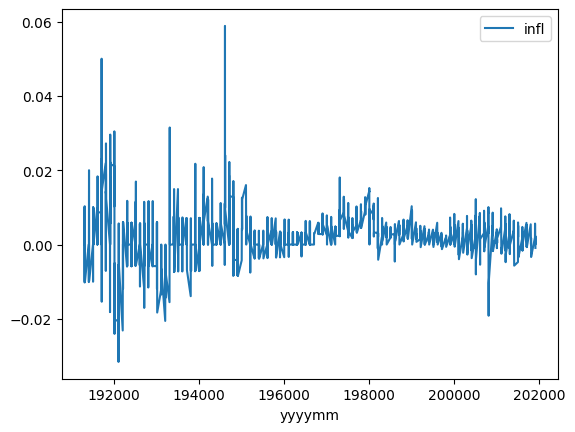

In [186]:
calced_monthly.plot(x='yyyymm',y='infl')

<Axes: xlabel='yyyy'>

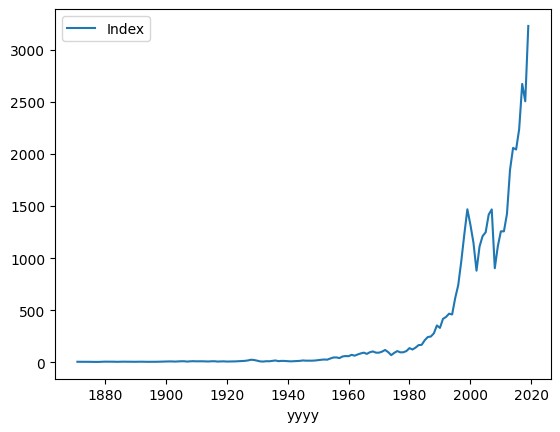

In [187]:
calced_yearly.plot(x='yyyy',y='Index')

<Axes: >

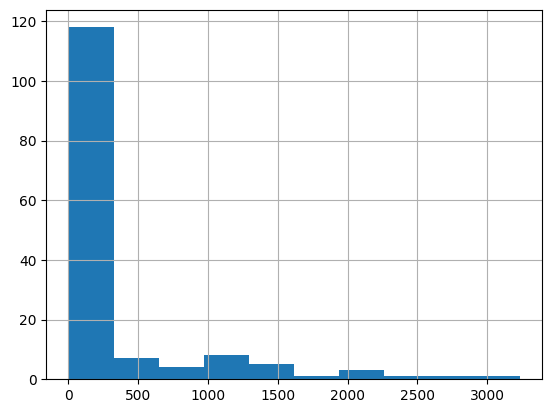

In [188]:
calced_yearly['Index'].hist()

In [189]:
df_list = {'monthly':calced_monthly, 
           'quarterly':calced_quarterly, 
           'yearly':calced_yearly}

In [190]:
# outliers based on 1.5*IQR
def outlier_calcs(df, name):
    bigholder = []
    for col in df.columns:
        smallholder = {}
        if 'yyyy' in col:
            continue
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        smallholder['df'] = name
        smallholder['col'] = col
        smallholder['count'] = df[(df[col] <= q1 - 1.5*iqr) | (df[col] >= q3 + 1.5*iqr)][col].count()
        smallholder['outlier_pct'] = smallholder['count']/len(df)
        smallholder['fill_rate'] = 1 - (df[col].isna().sum()/len(df))
        bigholder.append(smallholder)
    
    newdf = pd.DataFrame(bigholder)
    return newdf

In [191]:
outlier_df = pd.DataFrame()
for key, value in df_list.items():
    holder_df = outlier_calcs(value, key)
    outlier_df = pd.concat([outlier_df, holder_df], axis=0)

In [192]:
outlier_df[outlier_df['df'] == 'yearly']

,df,col,count,outlier_pct,fill_rate
0,yearly,Index,30,0.201342,1.000000
1,yearly,D12,18,0.120805,1.000000
2,yearly,E12,21,0.140940,1.000000
3,yearly,b/m,1,0.006711,0.664430
4,yearly,tbl,2,0.013423,0.671141
5,yearly,AAA,3,0.020134,0.677852
6,yearly,BAA,3,0.020134,0.677852
7,yearly,lty,1,0.006711,0.671141
8,yearly,cay,0,0.000000,0.503356
9,yearly,ntis,6,0.040268,0.630872


In [193]:
outlier_df[outlier_df['df'] == 'quarterly']

,df,col,count,outlier_pct,fill_rate
0,quarterly,Index,120,0.201342,1.000000
1,quarterly,D12,70,0.117450,1.000000
2,quarterly,E12,82,0.137584,1.000000
3,quarterly,b/m,3,0.005034,0.664430
4,quarterly,tbl,8,0.013423,0.671141
5,quarterly,AAA,10,0.016779,0.677852
6,quarterly,BAA,14,0.023490,0.677852
7,quarterly,lty,10,0.016779,0.671141
8,quarterly,cay,0,0.000000,0.456376
9,quarterly,ntis,22,0.036913,0.625839


In [194]:
outlier_df[outlier_df['df'] == 'monthly']

,df,col,count,outlier_pct,fill_rate
0,monthly,Index,361,0.201902,1.000000
1,monthly,D12,209,0.116890,1.000000
2,monthly,E12,243,0.135906,1.000000
3,monthly,b/m,10,0.005593,0.663311
4,monthly,tbl,26,0.014541,0.670582
5,monthly,AAA,26,0.014541,0.677852
6,monthly,BAA,40,0.022371,0.677852
7,monthly,lty,36,0.020134,0.671141
8,monthly,ntis,61,0.034116,0.624720
9,monthly,Rfree,44,0.024609,1.000000


## Question 2

Are there any features that are not stationary? If so, fractionally differentiate them. (16 points)


In [195]:
log_columns = ['ep','dp','dy','de']

In [196]:
def logtransform(df,col):
    x = pd.DataFrame(np.log(df[[col]]))
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x = x.dropna()
    x.rename(columns={col:col+'_log'}, inplace=True)
    return x

In [215]:
findMinD(monthlydf[['ntis']])

0.0

In [243]:
def check_if_stationaryv2(df, name):
    bigholder = []
    for col in df.columns:
        smallholder = {}
        if 'yyyy' in col:
            continue
        smallholder['df'] = name
        smallholder['col'] = col
        if findMinD(df[[col]]) == 1.0:
            smallholder['d_val'] = 1.0
            smallholder['stationary'] = True
            results = adfuller(df[col].dropna(), maxlag=1, regression='c', autolag=None)
            smallholder['crit'] = results[0]
            smallholder['pval'] = results[1]
            smallholder['1%_sig'] = results[4]['5%']
        else:
            smallholder['d_val'] = findMinD(df[[col]])
            d = findMinD(df[[col]])
            df_ = fracDiff_FFD(df[[col]],d,thres=0.01).dropna()
            results = adfuller(df_[col].dropna(), maxlag=1, regression='c', autolag=None)
            smallholder['stationary'] = False
            smallholder['fd_doublediff'] = True
            smallholder['fd_crit'] =  results[0]
            smallholder['fd_pval'] =  results[1]
            smallholder['fd_1%_sig'] =  results[4]['5%']
        bigholder.append(smallholder)
    
    newdf = pd.DataFrame(bigholder)
    return newdf    

In [246]:
def check_if_stationaryv3(df, name):
    bigholder = []
    for col in df.columns:
        smallholder = {}
        if 'yyyy' in col:
            continue
        smallholder['df'] = name
        smallholder['col'] = col
        if findMinD(logtransform(df, col)) == 1.0:
            smallholder['d_val'] = 1.0
            smallholder['no_transform_stationary'] = True
            results = adfuller(logtransform(df, col).dropna(), maxlag=1, regression='c', autolag=None)
            smallholder['crit'] = results[0]
            smallholder['pval'] = results[1]
            smallholder['1%_sig'] = results[4]['5%']
        else:
            smallholder['d_val'] = findMinD(logtransform(df, col))
            d = findMinD(logtransform(df, col))
            df_ = fracDiff_FFD(logtransform(df, col),d,thres=0.01).dropna()
            results = adfuller(df_[col+'_log'].dropna(), maxlag=1, regression='c', autolag=None)
            smallholder['no_transform_stationary'] = False
            smallholder['fd_doublediff'] = True
            smallholder['fd_crit'] =  results[0]
            smallholder['fd_pval'] =  results[1]
            smallholder['fd_1%_sig'] =  results[4]['5%']
        bigholder.append(smallholder)
    
    newdf = pd.DataFrame(bigholder)
    return newdf    

In [247]:
qq = check_if_stationaryv2(calced_monthly, 'monthly')

In [248]:
qq

,df,col,d_val,stationary,fd_doublediff,fd_crit,fd_pval,fd_1%_sig,crit,pval,1%_sig
0,monthly,Index,0.6,False,True,-3.136923,2.393868e-02,-2.863167,NaN,NaN,NaN
1,monthly,D12,1.0,True,NaN,NaN,NaN,NaN,4.047297,1.0,-2.86316
2,monthly,E12,0.7,False,True,-3.206448,1.961447e-02,-2.863165,NaN,NaN,NaN
3,monthly,b/m,0.0,False,True,-3.348177,1.285761e-02,-2.863984,NaN,NaN,NaN
4,monthly,tbl,0.1,False,True,-3.357641,1.249049e-02,-2.863972,NaN,NaN,NaN
5,monthly,AAA,0.3,False,True,-3.168506,2.188161e-02,-2.863954,NaN,NaN,NaN
6,monthly,BAA,0.3,False,True,-3.571317,6.333667e-03,-2.863954,NaN,NaN,NaN
7,monthly,lty,0.3,False,True,-3.541440,6.984459e-03,-2.863954,NaN,NaN,NaN
8,monthly,ntis,0.0,False,True,-3.753070,3.425665e-03,-2.864136,NaN,NaN,NaN
9,monthly,Rfree,0.0,False,True,-5.299809,5.480635e-06,-2.863160,NaN,NaN,NaN


: 

In [ ]:
qq

,df,col,d_val,stationary,fd_doublediff,fd_crit,fd_pval,fd_1%_sig,crit,pval,1%_sig
0,monthly,Index,0.6,False,True,-3.136923,2.393868e-02,-2.863167,NaN,NaN,NaN
1,monthly,D12,1.0,True,NaN,NaN,NaN,NaN,4.047297,1.0,-2.86316
2,monthly,E12,0.7,False,True,-3.206448,1.961447e-02,-2.863165,NaN,NaN,NaN
3,monthly,b/m,0.0,False,True,-3.348177,1.285761e-02,-2.863984,NaN,NaN,NaN
4,monthly,tbl,0.1,False,True,-3.357641,1.249049e-02,-2.863972,NaN,NaN,NaN
5,monthly,AAA,0.3,False,True,-3.168506,2.188161e-02,-2.863954,NaN,NaN,NaN
6,monthly,BAA,0.3,False,True,-3.571317,6.333667e-03,-2.863954,NaN,NaN,NaN
7,monthly,lty,0.3,False,True,-3.541440,6.984459e-03,-2.863954,NaN,NaN,NaN
8,monthly,ntis,0.0,False,True,-3.753070,3.425665e-03,-2.864136,NaN,NaN,NaN
9,monthly,Rfree,0.0,False,True,-5.299809,5.480635e-06,-2.863160,NaN,NaN,NaN


In [221]:
qqf = fracDiff_FFD(calced_monthly[['Index']], 0.6).dropna()

In [222]:
adfuller(qqf, maxlag=1, regression='c', autolag=None)

(-8.845925341439603,
 1.6208586041423206e-14,
 1,
 1197,
 {'1%': -3.4358248361156765,
  '5%': -2.8639575982634757,
  '10%': -2.5680571735171958})

In [211]:
def check_if_stationary(df, name):
    bigholder = []
    for col in df.columns:
        smallholder = {}
        if 'yyyy' in col:
            continue
        smallholder['df'] = name
        smallholder['col'] = col
        results = adfuller(df[col].dropna(), maxlag=1, regression='c', autolag=None)
        smallholder['crit'] = results[0]
        smallholder['pval'] = results[1]
        smallholder['1%_sig'] = results[4]['1%']
        if results[0] <= results[4]['1%']:
            smallholder['stationary'] = True
            smallholder['fd_crit'] = np.nan
            smallholder['fd_pval'] = np.nan
            smallholder['fd_1%_sig'] = np.nan
            
        else:
            smallholder['stationary'] = False
            not_stationary = True

            
            if col not in log_columns:
                logtransformed = logtransform(df,col)
                d = findMinD(logtransformed)
                logFD = fracDiff_FFD(logtransformed,d,thres=0.01).dropna()
                newresults = adfuller(logFD[col+'_log'], maxlag=1, regression='c', autolag=None)
                
                if newresults[0] <= newresults[4]['1%']:
                    smallholder['fd_doublediff'] = False
                    smallholder['fd_crit'] = newresults[0]
                    smallholder['fd_pval'] = newresults[1]
                    smallholder['fd_1%_sig'] = newresults[4]['1%']
                    smallholder['d_val'] = d
                else:
                    newd = findMinD(logFD)
                    doublediff = fracDiff_FFD(logFD,newd,thres=0.01).dropna()
                    newresults = adfuller(doublediff[col+'_log'], maxlag=1, regression='c', autolag=None)
                    smallholder['fd_doublediff'] = True
                    smallholder['fd_crit'] = newresults[0]
                    smallholder['fd_pval'] = newresults[1]
                    smallholder['fd_1%_sig'] = newresults[4]['1%']
                    smallholder['d_val'] = newd
                    if newresults[0] <= newresults[4]['1%']:
                        smallholder['fd_doublediff_worked'] = True
                    else:
                        smallholder['fd_doublediff_worked'] = False
            else:
                d = findMinD(df[[col]])
                logFD = fracDiff_FFD(df[[col]],d,thres=0.01).dropna()
                newresults = adfuller(logFD[col], maxlag=1, regression='c', autolag=None)
                if newresults[0] <= newresults[4]['1%']:
                    smallholder['fd_doublediff'] = False
                    smallholder['fd_crit'] = newresults[0]
                    smallholder['fd_pval'] = newresults[1]
                    smallholder['fd_1%_sig'] = newresults[4]['1%']
                    smallholder['d_val'] = d
                else:
                    newd = findMinD(logFD)
                    doublediff = fracDiff_FFD(logFD,newd,thres=0.01).dropna()
                    newresults = adfuller(doublediff[col], maxlag=1, regression='c', autolag=None)
                    smallholder['fd_doublediff'] = True
                    smallholder['fd_crit'] = newresults[0]
                    smallholder['fd_pval'] = newresults[1]
                    smallholder['fd_1%_sig'] = newresults[4]['1%']
                    smallholder['d_val'] = newd
                    if newresults[0] <= newresults[4]['1%']:
                        smallholder['fd_doublediff_worked'] = True
                    else:
                        smallholder['fd_doublediff_worked'] = False
            
        bigholder.append(smallholder)
    
    newdf = pd.DataFrame(bigholder)
    return newdf    

In [212]:
stationarity_df = pd.DataFrame()
for key, value in df_list.items():
    holder_df = check_if_stationary(value, key)
    stationarity_df = pd.concat([stationarity_df, holder_df], axis=0)

c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\tkkim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\t

In [213]:
stationarity_df[stationarity_df['df'] == 'yearly']

,df,col,crit,pval,1%_sig,stationary,fd_doublediff,fd_crit,fd_pval,fd_1%_sig,d_val,fd_doublediff_worked
0,yearly,Index,5.097311,1.000000e+00,-3.475637,False,False,-3.856145,0.002382,-3.477601,0.7,NaN
1,yearly,D12,4.913670,1.000000e+00,-3.475637,False,False,-3.597564,0.005808,-3.477601,0.7,NaN
2,yearly,E12,1.214101,9.960819e-01,-3.475637,False,False,-3.480445,0.008504,-3.478648,0.5,NaN
3,yearly,b/m,-2.758729,6.441510e-02,-3.499637,False,True,-2.982114,0.036599,-3.507853,0.0,False
4,yearly,tbl,-2.590346,9.500902e-02,-3.498910,False,True,-2.904338,0.044846,-3.506944,0.0,False
5,yearly,AAA,-1.176541,6.836051e-01,-3.498198,False,True,-3.360651,0.012376,-3.504343,0.0,False
6,yearly,BAA,-1.756982,4.020181e-01,-3.498198,False,True,-2.916097,0.043508,-3.506057,0.0,False
7,yearly,lty,-1.099199,7.153910e-01,-3.498910,False,True,-3.054074,0.030144,-3.506944,0.0,False
8,yearly,cay,-2.426041,1.345210e-01,-3.523284,False,True,-3.023836,0.032728,-3.688926,0.0,False
9,yearly,ntis,-4.898843,3.505568e-05,-3.503515,True,NaN,NaN,NaN,NaN,NaN,NaN
